# Antarctic SMB trends

Author: Ziqi Yin

Last edited: Jun 15, 2025

## Description

SMB and sea level pressure trends and anomalies:
- Simulation: CESM2-TPACE, CESM2-LE*, MT19
- Period: 1976:2000 minus 1901:1925; anomalies over 1901-2000

In [1]:
# Load Libraries
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import cartopy.util as util
import xarray as xr
import pandas as pd
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
from scipy.stats import linregress
import matplotlib.path as mpath
import matplotlib.colors as colors

import sys  
home_dir = '/glade/work/ziqiyin/'
sys.path.insert(0, home_dir)
sys.path.append(home_dir + 'function/')

from functions import *

ERROR 1: PROJ: proj_create_from_database: Open of /glade/work/ziqiyin/conda-envs/my-npl-202306a/share/proj failed


## Read data

In [ ]:
#CESM2-LE (10 members, 1850-2100, to compare with TPACE)
path = '/glade/campaign/cgd/cas/dschneid/SMB_variables_CESM2/large_ensemble_CESM2/TPACE_subset/'

fn_RAIN_LE10 = 'b.e21.BHISTcmip6.f09_g17.LE2-EM1-10.clm2.h0.RAIN.185001-210012.nc'
RAIN_LE10 = xr.open_dataset(path+fn_RAIN_LE10).RAIN #[mm/s]
fn_SNOW_LE10 = 'b.e21.BHISTcmip6.f09_g17.LE2-EM1-10.clm2.h0.SNOW.185001-210012.nc'
SNOW_LE10 = xr.open_dataset(path+fn_SNOW_LE10).SNOW
fn_QSOIL_LE10 = 'b.e21.BHISTcmip6.f09_g17.LE2-EM1-10.clm2.h0.QSOIL.185001-210012.nc'
QSOIL_LE10 = xr.open_dataset(path+fn_QSOIL_LE10).QSOIL
fn_QRUNOFF_LE10 = 'b.e21.BHISTcmip6.f09_g17.LE2-EM1-10.clm2.h0.QRUNOFF.185001-210012.nc'
QRUNOFF_LE10 = xr.open_dataset(path+fn_QRUNOFF_LE10).QRUNOFF
SMB_LE10 = RAIN_LE10 + SNOW_LE10 - QSOIL_LE10 - QRUNOFF_LE10

#CESM2-TPACE (10 members, 1880-2019)
path = '/glade/campaign/cgd/cas/dschneid/SMB_variables_CESM2/tropical_pacific_pacemaker/'

fn_RAIN_TPACE = 'b.e21.BHISTcmip6.f09_g17.pacemaker_pacific.EM1-10.clm2.h0.RAIN.188001-201912.nc'
RAIN_TPACE = xr.open_dataset(path+fn_RAIN_TPACE).RAIN
fn_SNOW_TPACE = 'b.e21.BHISTcmip6.f09_g17.pacemaker_pacific.EM1-10.clm2.h0.SNOW.188001-201912.nc'
SNOW_TPACE = xr.open_dataset(path+fn_SNOW_TPACE).SNOW
fn_QSOIL_TPACE = 'b.e21.BHISTcmip6.f09_g17.pacemaker_pacific.EM1-10.clm2.h0.QSOIL.188001-201912.nc'
QSOIL_TPACE = xr.open_dataset(path+fn_QSOIL_TPACE).QSOIL
fn_QRUNOFF_TPACE = 'b.e21.BHISTcmip6.f09_g17.pacemaker_pacific.EM1-10.clm2.h0.QRUNOFF.188001-201912.nc'
QRUNOFF_TPACE = xr.open_dataset(path+fn_QRUNOFF_TPACE).QRUNOFF
SMB_TPACE = RAIN_TPACE + SNOW_TPACE - QSOIL_TPACE - QRUNOFF_TPACE

In [2]:
## SMB and PSL variables
# MT19 La Nina composite (1976:2000 minus 1901:1925)
path = '/glade/work/dschneid/zaria_snow/revision1/'

fn_SMB_MTln = 'MT19_LaNina_composite.nc'
SMB_MTln = xr.open_dataset(path+fn_SMB_MTln).MT19_LaNina
lat_MTln = np.array(SMB_MTln.lat)
lon_MTln = np.array(SMB_MTln.lon)

# O'Connor La Nina composite
path = '/glade/work/dschneid/zaria_snow/revision1/'

fn_PSL_OCln = 'OC24_LaNina_composite_SLP.nc'
PSL_OCln = xr.open_dataset(path+fn_PSL_OCln).OC24_LaNina_SLP #[hPa]
lat_OCln = np.array(PSL_OCln.lat)
lon_OCln = np.array(PSL_OCln.lon)

# CESM2-TPACE internal and La Nina composite
path = '/glade/work/dschneid/zaria_snow/revision1/'

fn_TPACE = 'TPACE_LaNina_composites.nc'
SMB_TPACEit = xr.open_dataset(path+fn_TPACE).TPACE_internal_SMB
PSL_TPACEit = xr.open_dataset(path+fn_TPACE).TPACE_internal_SLP
SMB_TPACEln = xr.open_dataset(path+fn_TPACE).TPACE_LaNina_SMB
PSL_TPACEln = xr.open_dataset(path+fn_TPACE).TPACE_LaNina_SLP #Suggested SLP contour: 0.25 or 0.3 hPa
lat = SMB_TPACEit.lat
lon = SMB_TPACEit.lon

In [3]:
# Zwally grounded ice sheet land mask (REMOVAL of ice shelves)
path = '/glade/work/dschneid/zaria_snow/'

fn_GROUNDEDMASK = 'AIS_Groundedmask_Zwally_CESMgrid.nc'
GROUNDEDMASK = xr.open_dataset(path+fn_GROUNDEDMASK).Groundedmask

In [4]:
#Add cyclic points
SMB_TPACEit_full, lon_full = add_cyclic_point(SMB_TPACEit, coord=lon)
SMB_MTln_full, lon_MTln_full = add_cyclic_point(SMB_MTln, coord=lon_MTln)
SMB_TPACEln_full, lon_full = add_cyclic_point(SMB_TPACEln, coord=lon)

#slope_SMB_ERA5_full_2001_2022 = np.where(slope_SMB_ERA5_full_2001_2022 != 0, slope_SMB_ERA5_full_2001_2022, np.NaN)
#slope_SMB_LE_full_2001_2022 = np.where(slope_SMB_LE_full_2001_2022 != 0, slope_SMB_LE_full_2001_2022, np.NaN)
#slope_SMB_WNUDGE_full_2001_2022 = np.where(slope_SMB_WNUDGE_full_2001_2022 != 0, slope_SMB_WNUDGE_full_2001_2022, np.NaN)

In [5]:
#Add cyclic points
PSL_TPACEit_full, lon_full = add_cyclic_point(PSL_TPACEit, coord=lon)
PSL_OCln_full, lon_OCln_full = add_cyclic_point(PSL_OCln, coord=lon_OCln)
PSL_TPACEln_full, lon_full = add_cyclic_point(PSL_TPACEln, coord=lon)

#slope_msl_ERA5_full_2001_2022 = np.where(slope_msl_ERA5_full_2001_2022 != 0, slope_msl_ERA5_full_2001_2022, np.NaN)
#slope_PSL_LE_full_2001_2022 = np.where(slope_PSL_LE_full_2001_2022 != 0, slope_PSL_LE_full_2001_2022, np.NaN)
#slope_PSL_WNUDGE_full_2001_2022 = np.where(slope_PSL_WNUDGE_full_2001_2022 != 0, slope_PSL_WNUDGE_full_2001_2022, np.NaN)

## Plot

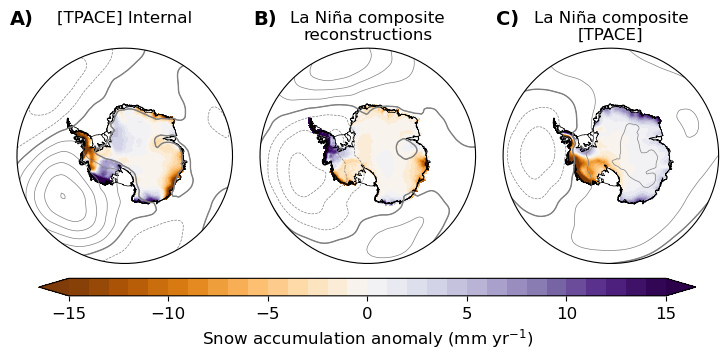

In [49]:
# Lat to S50
fig=plt.figure(figsize=(9,3.5))
gs=GridSpec(1,3)
plt.rcParams['axes.titlepad'] =14

#level_SMB = np.arange(-24., 24.01, 2.)
#ticks_SMB = np.arange(-24., 24.01, 8.)
level_SMB = np.arange(-15., 15.01, 1.)
ticks_SMB = np.arange(-15., 15.01, 5.)

level_PSL = np.arange(0-0.25*100, 0+0.25*101, 0.25)
level_PSL0 = np.arange(-100., 100.1, 100.)

size_title = 12
size_label = 12
size_tick = 12
size_text = 14
width_contour = 0.5

#cmap1 = colors.LinearSegmentedColormap.from_list("", ["darkred", "red", "orange", "gold", "white", "turquoise", "dodgerblue", "blue", "navy"])
cmap1 = 'PuOr'

######################### Coupled #########################
#SUBPLOT 1
ax1 = plt.subplot(gs[0], projection=ccrs.SouthPolarStereo())
plot_antarctica(ax1, -50)

im1=ax1.contourf(lon_full, lat, SMB_TPACEit_full, cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_SMB, extend='both')
im1b = ax1.contour(lon_full, lat, PSL_TPACEit_full, levels=level_PSL, linewidths=width_contour, colors=['gray'], transform=crs_ll)
im1c = ax1.contour(lon_full, lat, PSL_TPACEit_full, levels=level_PSL0, linewidths=width_contour+0.5, colors=['gray'], transform=crs_ll)

ax1.set_title('[TPACE] Internal\n'
              '', pad=8, fontsize=size_title)
ax1.text(-5000000, 5720000, 'A)', fontsize=size_text, fontweight='bold')
#ax1.text(-6000000, 6720000, 'A)', fontsize=size_text, fontweight='bold')

#SUBPLOT 2
ax2 = plt.subplot(gs[1], projection=ccrs.SouthPolarStereo())
plot_antarctica(ax2, -50)

im2=ax2.contourf(lon_MTln_full, lat_MTln, SMB_MTln_full, cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_SMB, extend='both')
im2b = ax2.contour(lon_OCln_full, lat_OCln, PSL_OCln_full, levels=level_PSL, linewidths=width_contour, colors=['gray'], transform=crs_ll)
im2c = ax2.contour(lon_OCln_full, lat_OCln, PSL_OCln_full, levels=level_PSL0, linewidths=width_contour+0.5, colors=['gray'], transform=crs_ll)

ax2.set_title('La Niña composite\n'
              'reconstructions', pad=8, fontsize=size_title)
ax2.text(-5000000, 5720000, 'B)', fontsize=size_text, fontweight='bold')

#SUBPLOT 3
ax3 = plt.subplot(gs[2], projection=ccrs.SouthPolarStereo())
plot_antarctica(ax3, -50)

im3=ax3.contourf(lon_full, lat, SMB_TPACEln_full, cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_SMB, extend='both')
im3b = ax3.contour(lon_full, lat, PSL_TPACEln_full, levels=level_PSL, linewidths=width_contour, colors=['gray'], transform=crs_ll)
im3c = ax3.contour(lon_full, lat, PSL_TPACEln_full, levels=level_PSL0, linewidths=width_contour+0.5, colors=['gray'], transform=crs_ll)

ax3.set_title('La Niña composite\n'
              '[TPACE]', pad=8, fontsize=size_title)
ax3.text(-5000000, 5720000, 'C)', fontsize=size_text, fontweight='bold')

#Colorbar
cbar_ax = fig.add_axes([0.147, 0.15, 0.73, 0.05]) #[from left, from bottom, width, height]
cbar = fig.colorbar(im1, cax=cbar_ax, orientation='horizontal', pad=.05, extend='both', boundaries=level_SMB, ticks=ticks_SMB)
cbar.ax.tick_params(labelsize=size_tick)
cbar.set_label('Snow accumulation anomaly (mm yr$^{-1}$)', size=size_label)


plt.subplots_adjust(#left=0.1,
                    #bottom=0.1,
                    #right=0.9,
                    #top=0.9,
                    wspace=0.15,
                    hspace=0.09)

plt.subplots_adjust(bottom=0.22)
plt.savefig('plot/S6_map_AIS_SMB_SLP_anomaly_latS50.jpg',dpi=300)
plt.show()

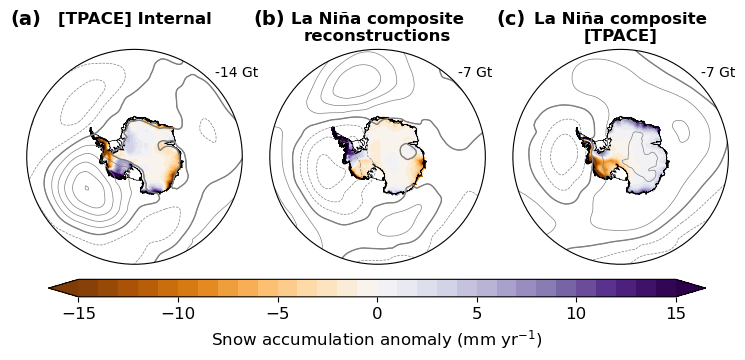

In [7]:
# Lat to S40
fig=plt.figure(figsize=(9,3.5))
gs=GridSpec(1,3)
plt.rcParams['axes.titlepad'] =14

#level_SMB = np.arange(-24., 24.01, 2.)
#ticks_SMB = np.arange(-24., 24.01, 8.)
level_SMB = np.arange(-15., 15.01, 1.)
ticks_SMB = np.arange(-15., 15.01, 5.)

level_PSL = np.arange(0-0.25*100, 0+0.25*101, 0.25)
level_PSL0 = np.arange(-100., 100.1, 100.)

size_title = 12
size_label = 12
size_tick = 12
size_text = 14
width_contour = 0.5

#cmap1 = colors.LinearSegmentedColormap.from_list("", ["darkred", "red", "orange", "gold", "white", "turquoise", "dodgerblue", "blue", "navy"])
cmap1 = 'PuOr'

######################### Coupled #########################
#SUBPLOT 1
ax1 = plt.subplot(gs[0], projection=ccrs.SouthPolarStereo())
plot_antarctica(ax1, -40)

im1=ax1.contourf(lon_full, lat, SMB_TPACEit_full, cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_SMB, extend='both')
im1b = ax1.contour(lon_full, lat, PSL_TPACEit_full, levels=level_PSL, linewidths=width_contour, colors=['gray'], transform=crs_ll)
im1c = ax1.contour(lon_full, lat, PSL_TPACEit_full, levels=level_PSL0, linewidths=width_contour+0.5, colors=['gray'], transform=crs_ll)

ax1.set_title('[TPACE] Internal\n'
              '', pad=8, fontsize=size_title, fontweight='bold')
ax1.text(-7000000, 7400000, '(a)', fontsize=size_text, fontweight='bold')
ax1.text(4500000, 4500000, '-14 Gt', fontsize=size_text-4)

#SUBPLOT 2
ax2 = plt.subplot(gs[1], projection=ccrs.SouthPolarStereo())
plot_antarctica(ax2, -40)

im2=ax2.contourf(lon_MTln_full, lat_MTln, SMB_MTln_full, cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_SMB, extend='both')
im2b = ax2.contour(lon_OCln_full, lat_OCln, PSL_OCln_full, levels=level_PSL, linewidths=width_contour, colors=['gray'], transform=crs_ll)
im2c = ax2.contour(lon_OCln_full, lat_OCln, PSL_OCln_full, levels=level_PSL0, linewidths=width_contour+0.5, colors=['gray'], transform=crs_ll)

ax2.set_title('La Niña composite\n'
              'reconstructions', pad=8, fontsize=size_title, fontweight='bold')
ax2.text(-7000000, 7400000, '(b)', fontsize=size_text, fontweight='bold')
ax2.text(4500000, 4500000, '-7 Gt', fontsize=size_text-4)

#SUBPLOT 3
ax3 = plt.subplot(gs[2], projection=ccrs.SouthPolarStereo())
plot_antarctica(ax3, -40)

im3=ax3.contourf(lon_full, lat, SMB_TPACEln_full, cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_SMB, extend='both')
im3b = ax3.contour(lon_full, lat, PSL_TPACEln_full, levels=level_PSL, linewidths=width_contour, colors=['gray'], transform=crs_ll)
im3c = ax3.contour(lon_full, lat, PSL_TPACEln_full, levels=level_PSL0, linewidths=width_contour+0.5, colors=['gray'], transform=crs_ll)

ax3.set_title('La Niña composite\n'
              '[TPACE]', pad=8, fontsize=size_title, fontweight='bold')
ax3.text(-7000000, 7400000, '(c)', fontsize=size_text, fontweight='bold')
ax3.text(4500000, 4500000, '-7 Gt', fontsize=size_text-4)

#Colorbar
cbar_ax = fig.add_axes([0.147, 0.15, 0.73, 0.05]) #[from left, from bottom, width, height]
cbar = fig.colorbar(im1, cax=cbar_ax, orientation='horizontal', pad=.05, extend='both', boundaries=level_SMB, ticks=ticks_SMB)
cbar.ax.tick_params(labelsize=size_tick)
cbar.set_label('Snow accumulation anomaly (mm yr$^{-1}$)', size=size_label)


plt.subplots_adjust(#left=0.1,
                    bottom=0.22,
                    #right=0.9,
                    #top=0.9,
                    wspace=0.15,
                    hspace=0.09)
plt.savefig(
    'plot/C5_map_AIS_SMB_SLP_anomaly_latS40.jpg',
    dpi=300,
    bbox_inches="tight",
    facecolor="w",
    transparent=False,
)

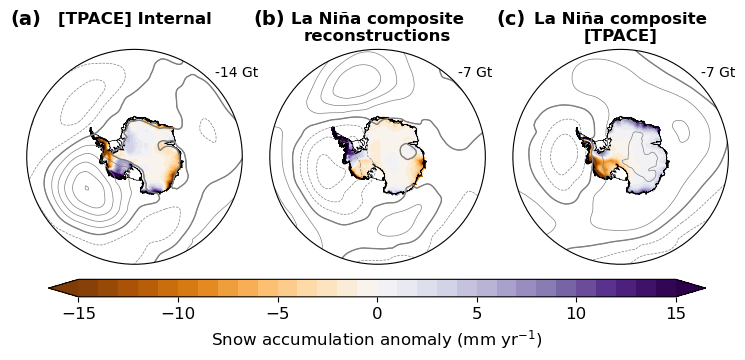

In [8]:
# Save in pdf format
fig=plt.figure(figsize=(9,3.5))
gs=GridSpec(1,3)
plt.rcParams['axes.titlepad'] =14

#level_SMB = np.arange(-24., 24.01, 2.)
#ticks_SMB = np.arange(-24., 24.01, 8.)
level_SMB = np.arange(-15., 15.01, 1.)
ticks_SMB = np.arange(-15., 15.01, 5.)

level_PSL = np.arange(0-0.25*100, 0+0.25*101, 0.25)
level_PSL0 = np.arange(-100., 100.1, 100.)

size_title = 12
size_label = 12
size_tick = 12
size_text = 14
width_contour = 0.5

#cmap1 = colors.LinearSegmentedColormap.from_list("", ["darkred", "red", "orange", "gold", "white", "turquoise", "dodgerblue", "blue", "navy"])
cmap1 = 'PuOr'

######################### Coupled #########################
#SUBPLOT 1
ax1 = plt.subplot(gs[0], projection=ccrs.SouthPolarStereo())
plot_antarctica(ax1, -40)

im1=ax1.contourf(lon_full, lat, SMB_TPACEit_full, cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_SMB, extend='both')
im1b = ax1.contour(lon_full, lat, PSL_TPACEit_full, levels=level_PSL, linewidths=width_contour, colors=['gray'], transform=crs_ll)
im1c = ax1.contour(lon_full, lat, PSL_TPACEit_full, levels=level_PSL0, linewidths=width_contour+0.5, colors=['gray'], transform=crs_ll)

ax1.set_title('[TPACE] Internal\n'
              '', pad=8, fontsize=size_title, fontweight='bold')
ax1.text(-7000000, 7400000, '(a)', fontsize=size_text, fontweight='bold')
ax1.text(4500000, 4500000, '-14 Gt', fontsize=size_text-4)

#SUBPLOT 2
ax2 = plt.subplot(gs[1], projection=ccrs.SouthPolarStereo())
plot_antarctica(ax2, -40)

im2=ax2.contourf(lon_MTln_full, lat_MTln, SMB_MTln_full, cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_SMB, extend='both')
im2b = ax2.contour(lon_OCln_full, lat_OCln, PSL_OCln_full, levels=level_PSL, linewidths=width_contour, colors=['gray'], transform=crs_ll)
im2c = ax2.contour(lon_OCln_full, lat_OCln, PSL_OCln_full, levels=level_PSL0, linewidths=width_contour+0.5, colors=['gray'], transform=crs_ll)

ax2.set_title('La Niña composite\n'
              'reconstructions', pad=8, fontsize=size_title, fontweight='bold')
ax2.text(-7000000, 7400000, '(b)', fontsize=size_text, fontweight='bold')
ax2.text(4500000, 4500000, '-7 Gt', fontsize=size_text-4)

#SUBPLOT 3
ax3 = plt.subplot(gs[2], projection=ccrs.SouthPolarStereo())
plot_antarctica(ax3, -40)

im3=ax3.contourf(lon_full, lat, SMB_TPACEln_full, cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_SMB, extend='both')
im3b = ax3.contour(lon_full, lat, PSL_TPACEln_full, levels=level_PSL, linewidths=width_contour, colors=['gray'], transform=crs_ll)
im3c = ax3.contour(lon_full, lat, PSL_TPACEln_full, levels=level_PSL0, linewidths=width_contour+0.5, colors=['gray'], transform=crs_ll)

ax3.set_title('La Niña composite\n'
              '[TPACE]', pad=8, fontsize=size_title, fontweight='bold')
ax3.text(-7000000, 7400000, '(c)', fontsize=size_text, fontweight='bold')
ax3.text(4500000, 4500000, '-7 Gt', fontsize=size_text-4)

#Colorbar
cbar_ax = fig.add_axes([0.147, 0.15, 0.73, 0.05]) #[from left, from bottom, width, height]
cbar = fig.colorbar(im1, cax=cbar_ax, orientation='horizontal', pad=.05, extend='both', boundaries=level_SMB, ticks=ticks_SMB)
cbar.ax.tick_params(labelsize=size_tick)
cbar.set_label('Snow accumulation anomaly (mm yr$^{-1}$)', size=size_label)


plt.subplots_adjust(#left=0.1,
                    bottom=0.22,
                    #right=0.9,
                    #top=0.9,
                    wspace=0.15,
                    hspace=0.09)
plt.savefig(
    "plot/C5_map_AIS_SMB_SLP_anomaly_latS40.pdf",
    bbox_inches="tight",
    facecolor="w",
    transparent=False,
)